In [14]:
import math
import random
import matplotlib
import matplotlib.pyplot as plt

from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from env_2actions import *
#from env_3actions import *

In [15]:
env = Environment()

device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "mps" if torch.backends.mps.is_available() else
    "cpu"
)

In [16]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [17]:
class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 256)
        self.layer2 = nn.Linear(256, 128)
        #self.layer4 = nn.Linear(256,256)
        self.layer3 = nn.Linear(128, n_actions)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        #x = F.relu(self.layer4(x))
        #x = self.layer3(x)
        return self.layer3(x)
        #return F.softmax(x, dim=1)

In [18]:
# class DQN(nn.Module):
#     def __init__(self, input_layer, output_layer):
#         super().__init__()
        
#         self.net = nn.Sequential(
#             nn.Linear(input_layer,32),
#             nn.PReLU(),
#             nn.Linear(32, 256),       
#             nn.Dropout(p=0.15),              
#             nn.PReLU(),
#             nn.Linear(256, 512),       
#             nn.Dropout(p=0.15),              
#             nn.PReLU(),                       
#             nn.Linear(512, 256),
#             nn.Dropout(p=0.15),  
#             nn.PReLU(),
#             nn.Linear(256, 32),
#             nn.Dropout(p=0.15),  
#             nn.PReLU(),  
#             nn.Linear(32, output_layer)            
#         )
        
#     def forward(self, x):
#         return self.net(x)

In [19]:
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4
#n_actions = ncomp * nacomp ** ncomp
n_actions = nacomp ** ncomp

state = env.reset()
n_observations = state.shape[0] * state.shape[1] * state.shape[2] * state.shape[3] + 1

In [20]:
policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
optimizer = optim.Adam(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(2000)
steps_done = 0

In [21]:
import itertools

#actions_list = list(itertools.product([0, 1, 2], repeat=ncomp))  # All possible action combinations (32 combinations for 5 components)
actions_list = list(itertools.product([0, 1], repeat=ncomp))


In [22]:
def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            probs = policy_net(state)
            best_row_idx = probs.argmax()
            best_actions = actions_list[best_row_idx]  # This will be a tuple like (0, 1, 2, 0, 1)
            # Convert to a tensor (optional, if needed)
            best_actions_tensor = torch.tensor(best_actions).view(1,5)
            return best_row_idx, best_actions_tensor  # Shape: [1, 5]
    else:
        #print('Exploring')
        random_number = np.random.randint(0,len(actions_list))
        random_actions = actions_list[random_number]
        random_actions_tensor = torch.tensor(random_actions).view(1,5)
        return random_number, random_actions_tensor
        #return torch.randint(0, 2, (1, ncomp), device=device)

In [23]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
    
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.tensor(batch.reward, device=device, dtype=torch.float32)
    
    # expected_state_action_values = (next_state_values * GAMMA) + reward_batch.unsqueeze(1)
    state_action_values = policy_net(state_batch).gather(1, action_batch)
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch
    #print(state_action_values.shape,expected_state_action_values.shape)
    criterion = nn.MSELoss(reduction="sum")
    #criterion = nn.CrossEntropyLoss(reduction="mean")
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()


In [24]:
if torch.cuda.is_available() or torch.backends.mps.is_available():
    num_episodes = 600
else:
    num_episodes = int(1e5)


In [25]:
episode_durations = []
average_ep_cost = []
average_episodes = []
reward_history = []
total_ep_cost = np.zeros(num_episodes)

In [26]:
total_ep_cost = np.zeros(num_episodes)
best_average_cost = float('inf')  # Initialize to a large value
for i_episode in range(1,num_episodes+1):
    # Initialize the environment and get its state
    state = env.reset()
    reward = 0
    state_tensor = torch.tensor(state, dtype=torch.float32, device=device).view(1, -1)
    for t in range(1,51):
        state_tensor = torch.cat((state_tensor,torch.tensor([[t/50]], dtype=torch.float32, device=device)),dim = 1)
        action_index, action = select_action(state_tensor)
        #action_index = action_index/len(actions_list)
        #print(action)
        reward = immediatecost(action, cost_comp_action)
        if is_system_failed(state):
            reward -= 2400
            #print('Failed')
        total_ep_cost[i_episode-1] += GAMMA**(t-1)*reward
        #print(reward)
        if t==50:
            next_state = None
            break
        else:
            next_state, terminated, truncated, observations = env.step(state,action,t)
            #next_state_tensor = torch.tensor(next_state, dtype=torch.float32, device=device).unsqueeze(0) if next_state is not None else None
            next_state_tensor = torch.tensor(next_state, dtype=torch.float32, device=device).view(1, -1) if next_state is not None else None
            next_s_tensor = torch.cat((next_state_tensor, torch.tensor([[(t+1)/50]], dtype=torch.float32, device=device)), dim=1)
        # Store the transition in memory
        #memory.push(state_tensor, action, next_state_tensor, reward)#total_ep_cost[i_episode-1])
        memory.push(state_tensor, torch.tensor([[action_index]]), next_s_tensor, reward)
        state_tensor = next_state_tensor
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()

    reward_history.append(total_ep_cost[i_episode-1])

    #print(i_episode, total_ep_cost[i_episode-1])
    if i_episode >= 100:
            avg_cost = sum(reward_history[i_episode - 100:i_episode]) / 100
            average_ep_cost.append(avg_cost)
            average_episodes.append(i_episode)

            # if avg_cost < best_average_cost:
            #     best_average_cost = avg_cost
            #     torch.save(policy_net.state_dict(), 'policy_net.pth')
    if i_episode % 100 == 0:
         print(f'Episode number: {i_episode}, average_reward: {average_ep_cost[-1]}')
    target_net_state_dict = target_net.state_dict()
    policy_net_state_dict = policy_net.state_dict()
    # if i_episode % 100 == 0:
    #     for key in policy_net_state_dict:
    #         target_net_state_dict[key] = policy_net_state_dict[key]
    for key in policy_net_state_dict:
        target_net_state_dict[key] = policy_net_state_dict[key] * TAU + target_net_state_dict[key] * (1 - TAU)
    target_net.load_state_dict(target_net_state_dict)

Episode number: 100, average_reward: -9641.257194493925
Episode number: 200, average_reward: -6984.491226191135
Episode number: 300, average_reward: -15229.16864489764
Episode number: 400, average_reward: -8034.844961524216
Episode number: 500, average_reward: -4350.884575334352
Episode number: 600, average_reward: -4612.730041934766
Episode number: 700, average_reward: -3756.344002096015
Episode number: 800, average_reward: -2438.8436315823556
Episode number: 900, average_reward: -2306.088349353702
Episode number: 1000, average_reward: -2431.1229925301363
Episode number: 1100, average_reward: -2341.317377092236
Episode number: 1200, average_reward: -2383.1690636421367
Episode number: 1300, average_reward: -2150.399811848549
Episode number: 1400, average_reward: -2801.8629289147007
Episode number: 1500, average_reward: -2881.3509528845766
Episode number: 1600, average_reward: -2588.9856649370486
Episode number: 1700, average_reward: -3288.371799549078
Episode number: 1800, average_rewa

KeyboardInterrupt: 

50000


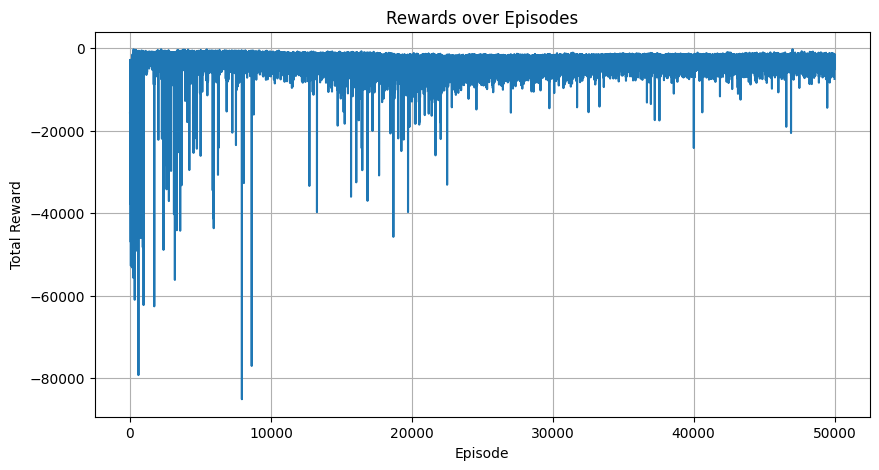

In [86]:
plt.figure(figsize=(10, 5))  # Optional: Set figure size for better visibility
print(len(reward_history))
plt.plot(range(1, len(reward_history) + 1), reward_history)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Rewards over Episodes')  # Optional: Add a title for clarity
plt.grid(True)  # Optional: Add grid for better readability
plt.show() 

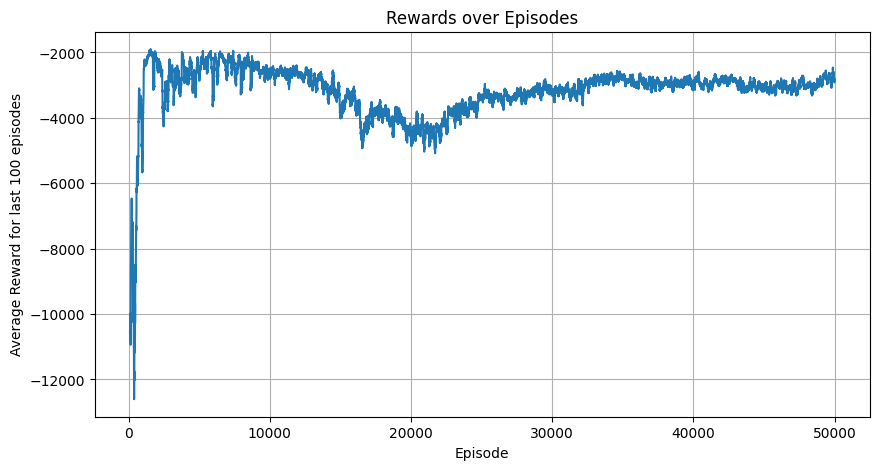

In [87]:
plt.figure(figsize=(10, 5))  # Optional: Set figure size for better visibility
plt.plot(average_episodes, average_ep_cost)
plt.xlabel('Episode')
plt.ylabel('Average Reward for last 100 episodes')
plt.title('Rewards over Episodes')  # Optional: Add a title for clarity
plt.grid(True)  # Optional: Add grid for better readability
plt.show()

In [88]:
torch.save(policy_net.state_dict(), 'policy_net.pth')
loaded_policy_net = DQN(n_observations, n_actions).to(device)
loaded_policy_net.load_state_dict(torch.load('policy_net.pth'))
loaded_policy_net.eval()

C:\Users\venka\AppData\Local\Temp\ipykernel_8764\1218210518.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_policy_net.load_state_dict(torch.load('policy_net.pth'

DQN(
  (layer1): Linear(in_features=21, out_features=256, bias=True)
  (layer2): Linear(in_features=256, out_features=128, bias=True)
  (layer3): Linear(in_features=128, out_features=32, bias=True)
)

In [89]:
def select_action_after_training(state):
    with torch.no_grad():
        probs = loaded_policy_net(state)
        best_row_idx = probs.argmax()
        best_actions = actions_list[best_row_idx]  # This will be a tuple like (0, 1, 2, 0, 1)
        # Convert to a tensor (optional, if needed)
        best_actions_tensor = torch.tensor(best_actions).view(1,5)
        return best_row_idx, best_actions_tensor  # Shape: [1, 5]
    

In [112]:
state = env.reset()
reward = 0
ep_cost = 0
state_tensor = torch.tensor(state, dtype=torch.float32, device=device).view(1, -1)
state_beliefs = []
actions_ = []
for t in range(1,51):
    state_tensor = torch.cat((state_tensor,torch.tensor([[t]], dtype=torch.float32, device=device)),dim = 1)
    state_beliefs.append(state.copy())
    action_index, action = select_action_after_training(state_tensor)
    #actions_.append(action.squeeze().tolist())
    actions_.append(action)
    reward = immediatecost(action, cost_comp_action)
    if is_system_failed(state):
        reward -= 2400
    ep_cost += GAMMA**(t-1)*reward
    if t==50:
        next_state = None
        break
    else:
        next_state, terminated, truncated, observations = env.step(state,action,t)
        #next_state_tensor = torch.tensor(next_state, dtype=torch.float32, device=device).unsqueeze(0) if next_state is not None else None
        next_state_tensor = torch.tensor(next_state, dtype=torch.float32, device=device).view(1, -1) if next_state is not None else None
        next_s_tensor = torch.cat((next_state_tensor, torch.tensor([[t+1]], dtype=torch.float32, device=device)), dim=1)
    # Store the transit ion in memory
    #memory.push(state_tensor, action, next_state_tensor, reward)#total_ep_cost[i_episode-1])
    state_tensor = next_state_tensor
    state = next_state

print(ep_cost)
print(actions_)


-2909.2252769694787
[tensor([[1, 0, 0, 0, 0]]), tensor([[1, 0, 0, 0, 0]]), tensor([[1, 0, 0, 0, 0]]), tensor([[1, 0, 0, 0, 0]]), tensor([[1, 0, 0, 0, 0]]), tensor([[1, 0, 0, 0, 0]]), tensor([[1, 0, 0, 0, 0]]), tensor([[1, 0, 0, 0, 0]]), tensor([[0, 0, 1, 0, 0]]), tensor([[0, 0, 1, 0, 0]]), tensor([[0, 0, 1, 0, 0]]), tensor([[0, 0, 1, 0, 0]]), tensor([[0, 0, 1, 0, 0]]), tensor([[0, 0, 1, 0, 0]]), tensor([[0, 0, 1, 0, 0]]), tensor([[0, 0, 1, 0, 0]]), tensor([[0, 0, 1, 0, 0]]), tensor([[0, 0, 1, 0, 0]]), tensor([[0, 0, 1, 0, 0]]), tensor([[0, 0, 1, 0, 0]]), tensor([[0, 1, 0, 0, 0]]), tensor([[0, 0, 1, 0, 0]]), tensor([[0, 0, 1, 0, 0]]), tensor([[0, 0, 1, 0, 0]]), tensor([[0, 0, 1, 0, 0]]), tensor([[0, 0, 1, 0, 0]]), tensor([[0, 0, 1, 0, 0]]), tensor([[0, 0, 1, 0, 0]]), tensor([[0, 0, 1, 0, 0]]), tensor([[0, 0, 1, 0, 0]]), tensor([[0, 1, 0, 0, 0]]), tensor([[0, 0, 1, 0, 0]]), tensor([[0, 1, 0, 0, 0]]), tensor([[0, 1, 0, 0, 0]]), tensor([[0, 1, 0, 0, 0]]), tensor([[0, 1, 0, 0, 0]]), tensor(

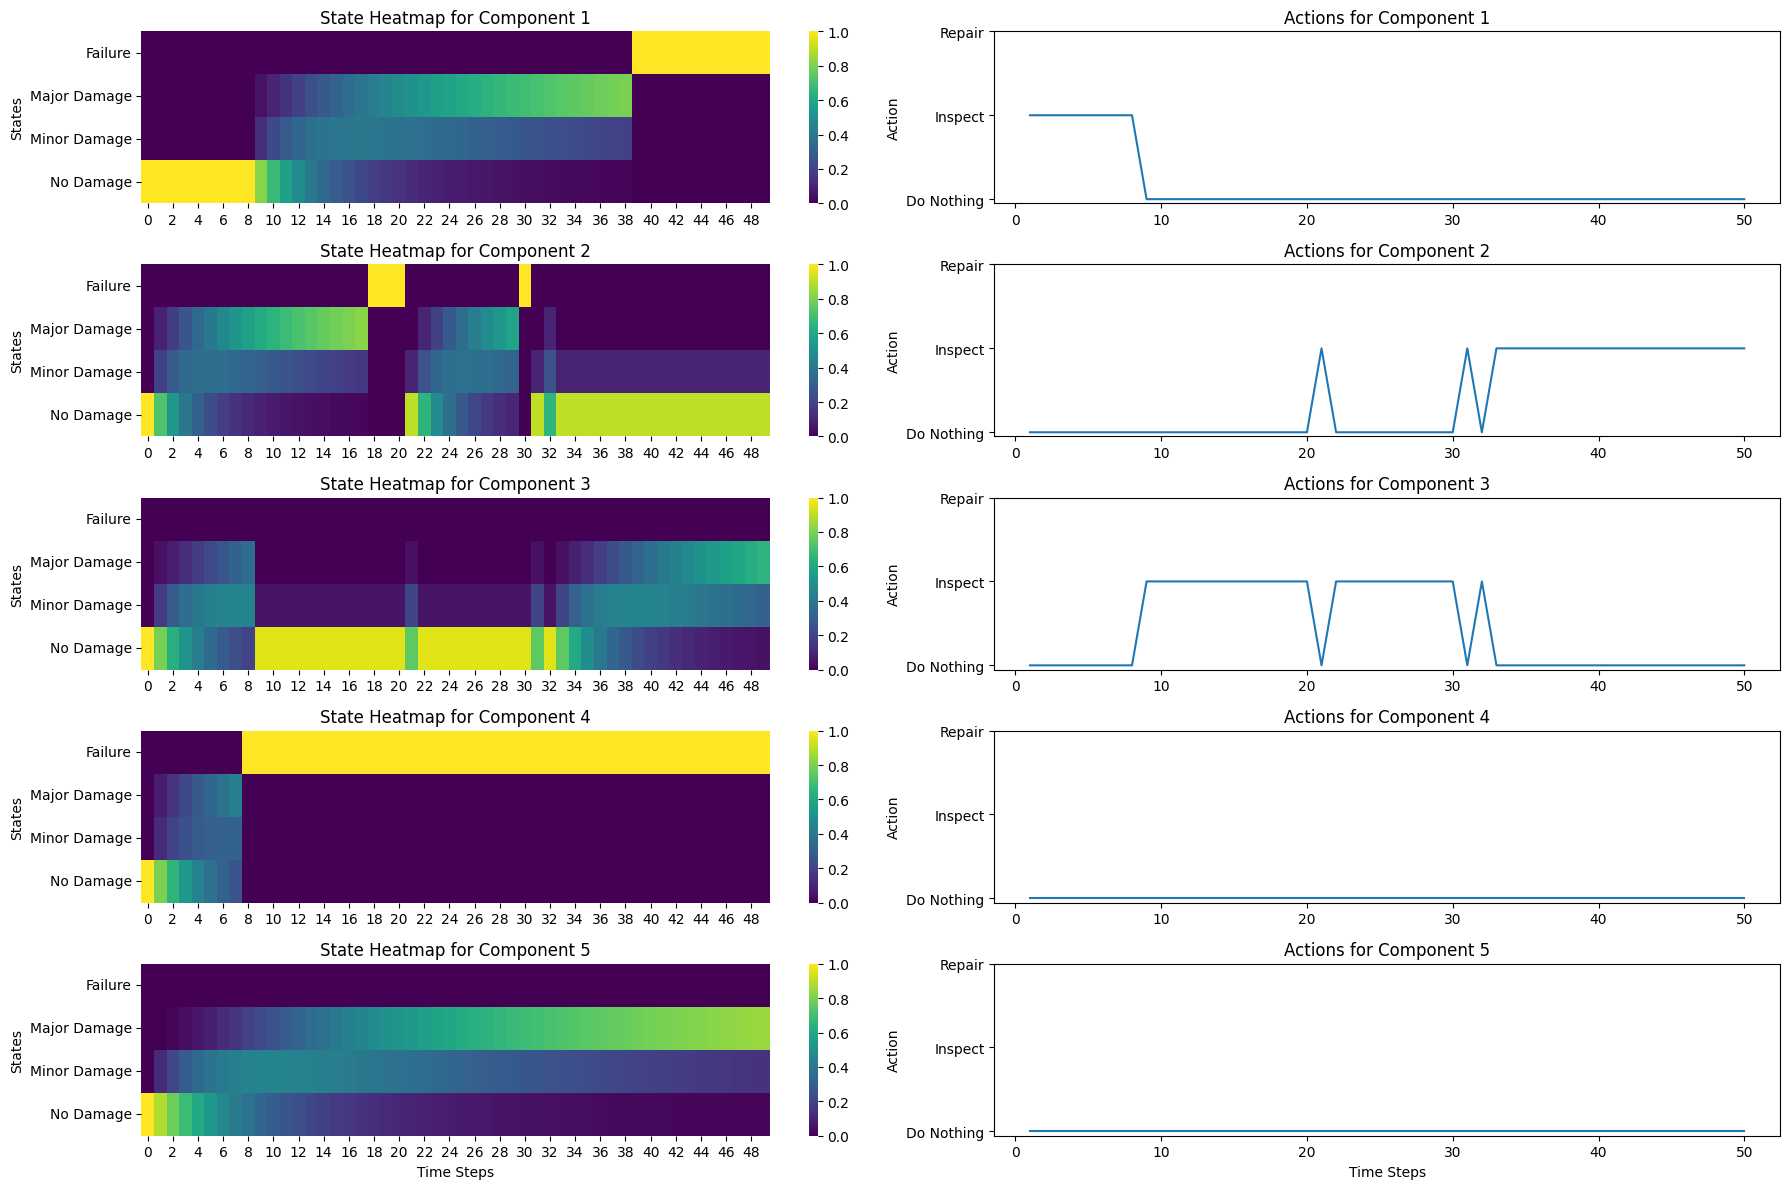

In [113]:
import seaborn as sns
fig, axes = plt.subplots(ncomp, 2, figsize=(18, 12), gridspec_kw={'width_ratios': [1, 1]})

if not isinstance(actions_, np.ndarray):
    actions_ = np.array(actions_)
if not isinstance(state_beliefs,np.ndarray):
    state_beliefs = np.array(state_beliefs)           
state_beliefs_squeezed = state_beliefs.squeeze(axis=(1, 4))
for i in range(ncomp):
    # Heatmap
    sns.heatmap(state_beliefs_squeezed[:, i, :].T, ax=axes[i, 0], cmap='viridis',  # Time steps (1-50)
                yticklabels=['No Damage', 'Minor Damage', 'Major Damage', 'Failure'])
    
    # Set titles and labels for heatmap
    axes[i, 0].set_title(f'State Heatmap for Component {i + 1}')
    axes[i, 0].set_ylabel('States')
    axes[i, 0].invert_yaxis()  # Invert y-axis to have state 1 at the bottom
    y_tick_labels = ['Do Nothing', 'Inspect', 'Repair']
    # Action plot
    axes[i, 1].plot(range(1, 51), actions_[:, :, i])
    axes[i, 1].set_title(f'Actions for Component {i + 1}')
    axes[i, 1].set_ylabel('Action')
    axes[i, 1].set_yticks(range(len(y_tick_labels)))  # Set y-ticks to [0, 1, 2]
    axes[i, 1].set_yticklabels(y_tick_labels)  # Set custom y-tick labels
    axes[i, 1].grid(False)

# Set common labels for the x-axis
axes[-1, 0].set_xlabel('Time Steps')  # X-label for the first column
axes[-1, 1].set_xlabel('Time Steps')  # X-label for the second column
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()